**Libraries**

In [2]:
!pip install cartopy
!pip install --no-binary shapely shapely --force
!pip install beautifulsoup4
!pip install requests
!pip install geopandas

from bs4 import BeautifulSoup      #reads data from website (web scraping)
import os                          #for working with directories
import requests                    #useful for sending HTTP requests using python
import shutil                      #useful for creating zip files
import numpy as np                 #for array manipulation
import pandas as pd                #for data querying and processing
import geopandas as gpd            #same as pandas, but for geospatial data
import matplotlib.pyplot as plt    #for creating plots
import cartopy.crs as ccrs         #for creating geographical maps
import cartopy.feature as cfeature
from copy import deepcopy as dc
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 62.0 MB/s eta 0:00:00
  Created wheel for shapely: filename=shapely-2.0.2-cp310-cp310-linux_x86_64.whl size=1028943 sha256=c22b986cb11641e9cc69abf229e4b47fc828b0c87314c0f729e05991c798d9cf
  Stored in directory: /root/.cache/pip/wheels/1f/6b/52/14cb4558cddc0fd89de08f0e1fd08f816f4f3e1969311377c6
Successfully built shapely
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.2
    Uninstalling shapely-2.0.2:
      Successful

**Outputs**

In [3]:
from google.colab import files      #ensures output zip file can be downloaded
from google.colab import drive      #imports local google drive
drive.mount('/drive')               #mounts local google drive onto colab
!mkdir Output                       #makes directory where output files will be stored

Mounted at /drive


**Inputs**

In [18]:
dt_initial = '20240101'  #Must be in YYYYMMDD format
dt_final = '20240107'
level = 1.5              #Level 1.0, 1.5, or 2.0 available
avg = 1                  #Daily averages (1), Hourly (2), or site total (3)
feature_choice = 'AOD'   #Available Inversion products: CAD, TAB, AOD, SSA
inv_type = 'ALM'         #Available Inversion types: ALM, HYB
wave = 440               #Wavelength of interest
geog_choice = 1          #To specify coordinates (1) or for all locations (2)

**Validation**

In [22]:
dt_initial = dt_initial.replace("-","").replace("/","").replace(" ","")
dt_final = dt_final.replace("-","").replace("/","").replace(" ","")

level = str(level).replace(".","")
feature_choice = feature_choice.upper()
inv_type = inv_type.upper()

if avg == 1:
    average_type = '20'
elif avg == 2 or avg == 3:
    average_type = '10'
else:
    average_type = '20' #will default to daily averages for improper input

if feature_choice == 'SSA':
    vis_min = 0.50
    vis_max = 1.00
elif feature_choice == 'CAD':
    vis_min = 0.00
    vis_max = 0.25
elif feature_choice == 'TAB':
    vis_min = 0.00
    vis_max = 0.05
else:
    vis_min = 0.00
    vis_max = 0.25

if geog_choice == 1:
    input_lat = input("Enter the map latitude bounds, separated by comma (south, north): ")
    lat_south_str, lat_north_str = input_lat.split(',')
    lat1 = float(lat_south_str)
    lat2 = float(lat_north_str)

    input_long = input("Enter the map longitude bounds, separated by comma (west, east): ")
    long_west_str, long_east_str = input_long.split(',')
    lon1 = float(long_west_str)
    lon2 = float(long_east_str)
else:
    lat1, lat2, lon1, lon2 = -90.0, 90.0, -180.0, 180.0

Enter the map latitude bounds, separated by comma (south, north): 0, 60
Enter the map longitude bounds, separated by comma (west, east): -150, -60


**Processing**

In [23]:
yr_initial = dt_initial[:4]               #initial year
mon_initial = dt_initial[4:6]             #initial month
day_initial = dt_initial[6:]              #initial day

yr_final = dt_final[:4]                   #final year
mon_final = dt_final[4:6]                 #final month
day_final = dt_final[6:]                  #final day

geog_construct = "lat1="+str(lat1)+"&lon1="+str(lon1)+"&lat2="+str(lat2)+"&lon2="+str(lon2)
url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_inv_v3?'+geog_construct+'&year='+yr_initial+'&month='+mon_initial+'&day='+day_initial+'&year2='+yr_final+'&month2='+mon_final+'&day2='+day_final+'&product='+feature_choice+'&AVG='+average_type+'&'+inv_type+str(level)+'=1'
soup = BeautifulSoup(requests.get(url).text) #web services contents are read here from URL

**Main**

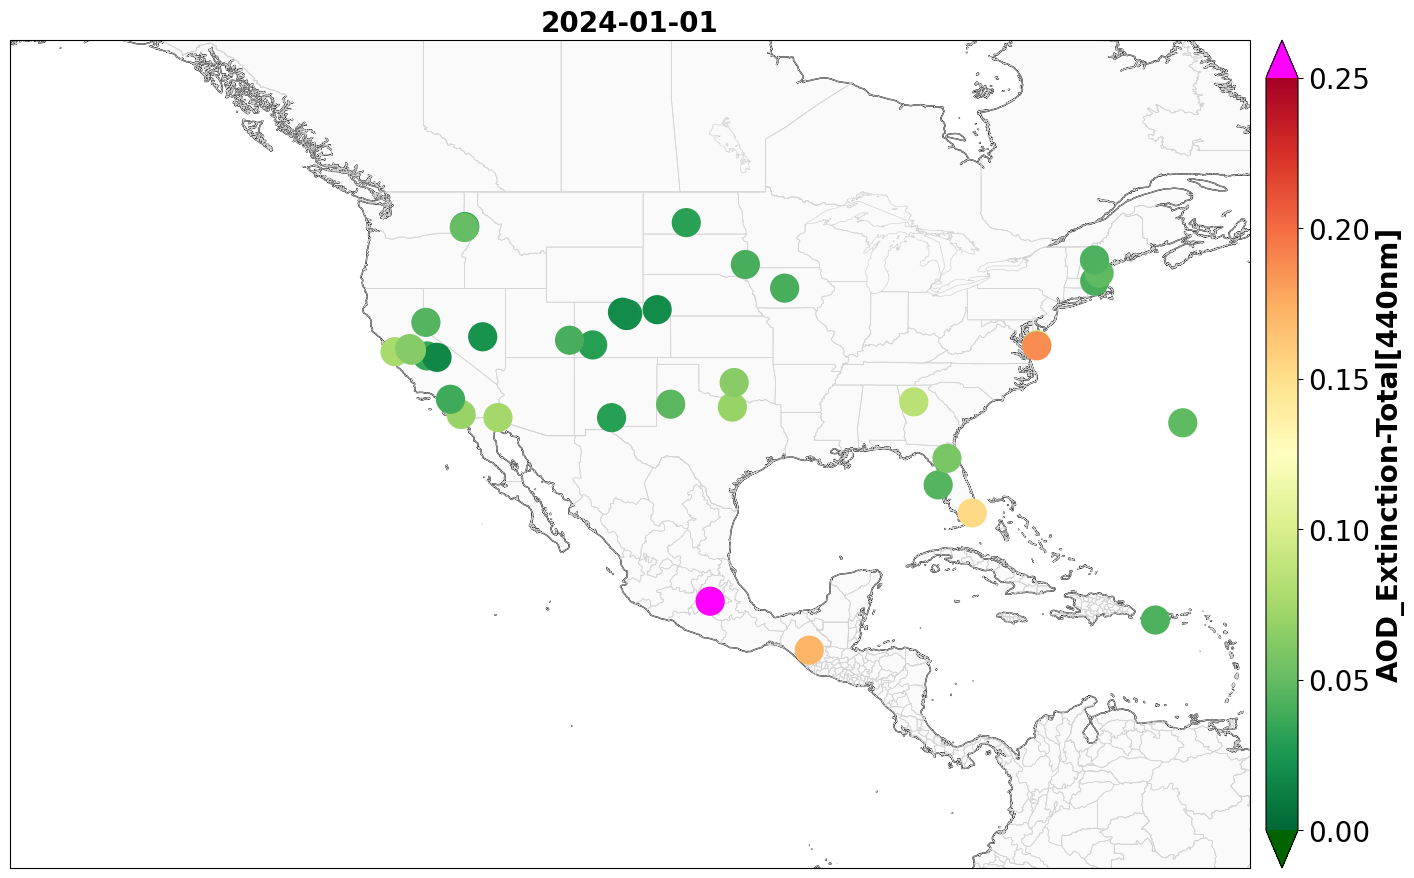

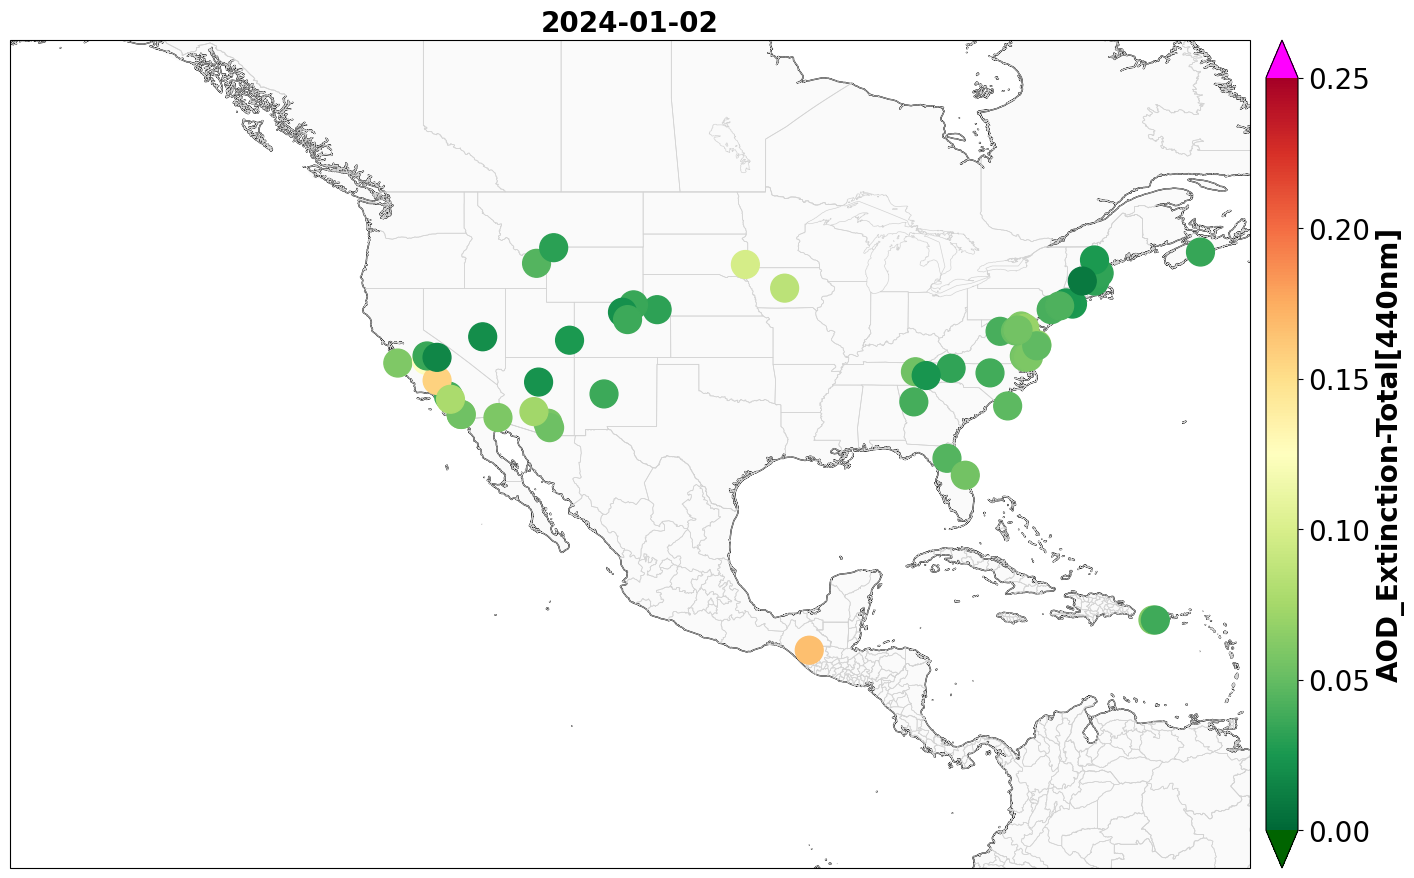

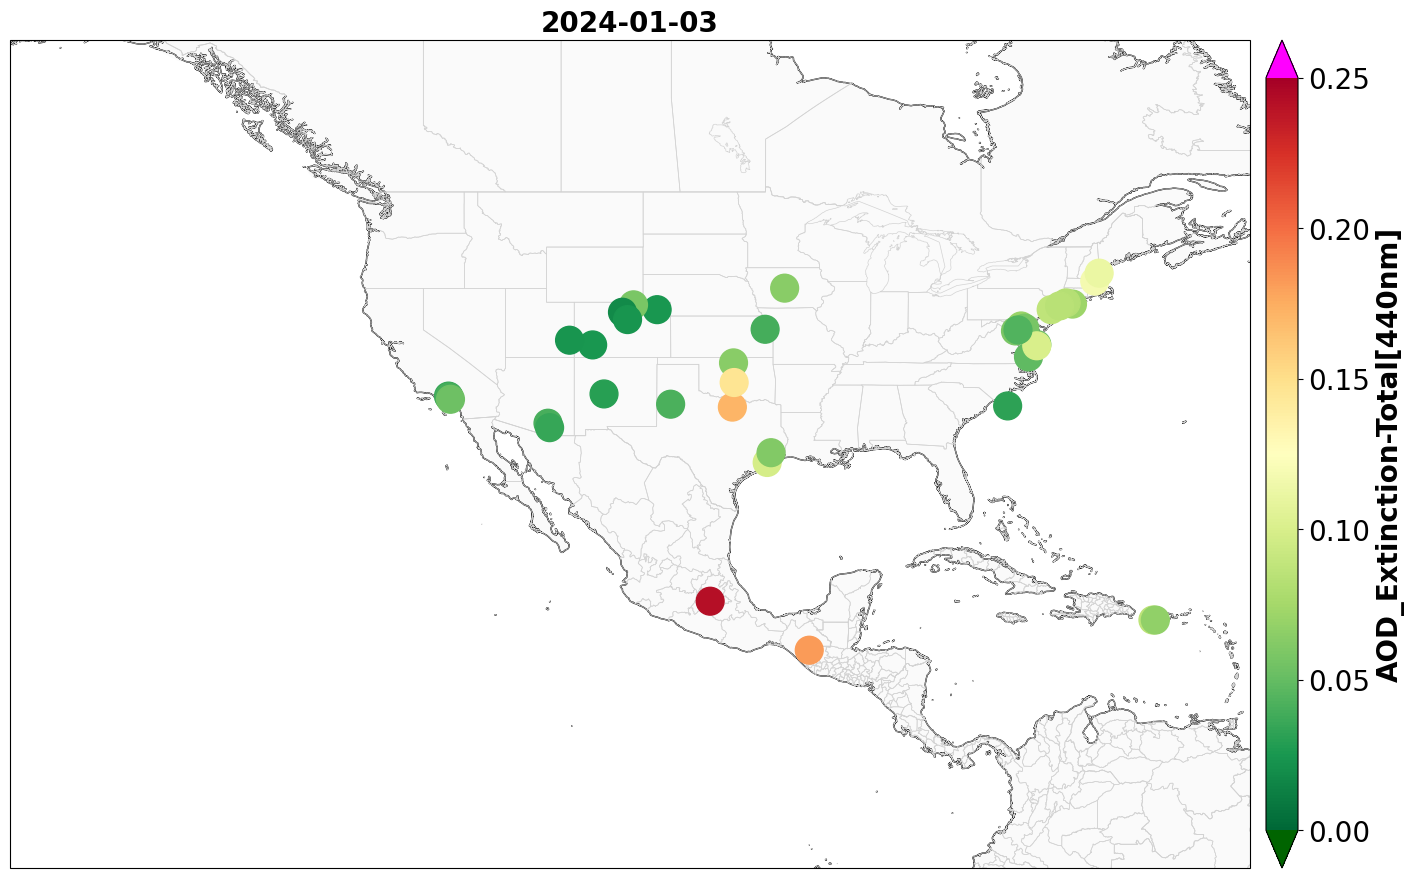

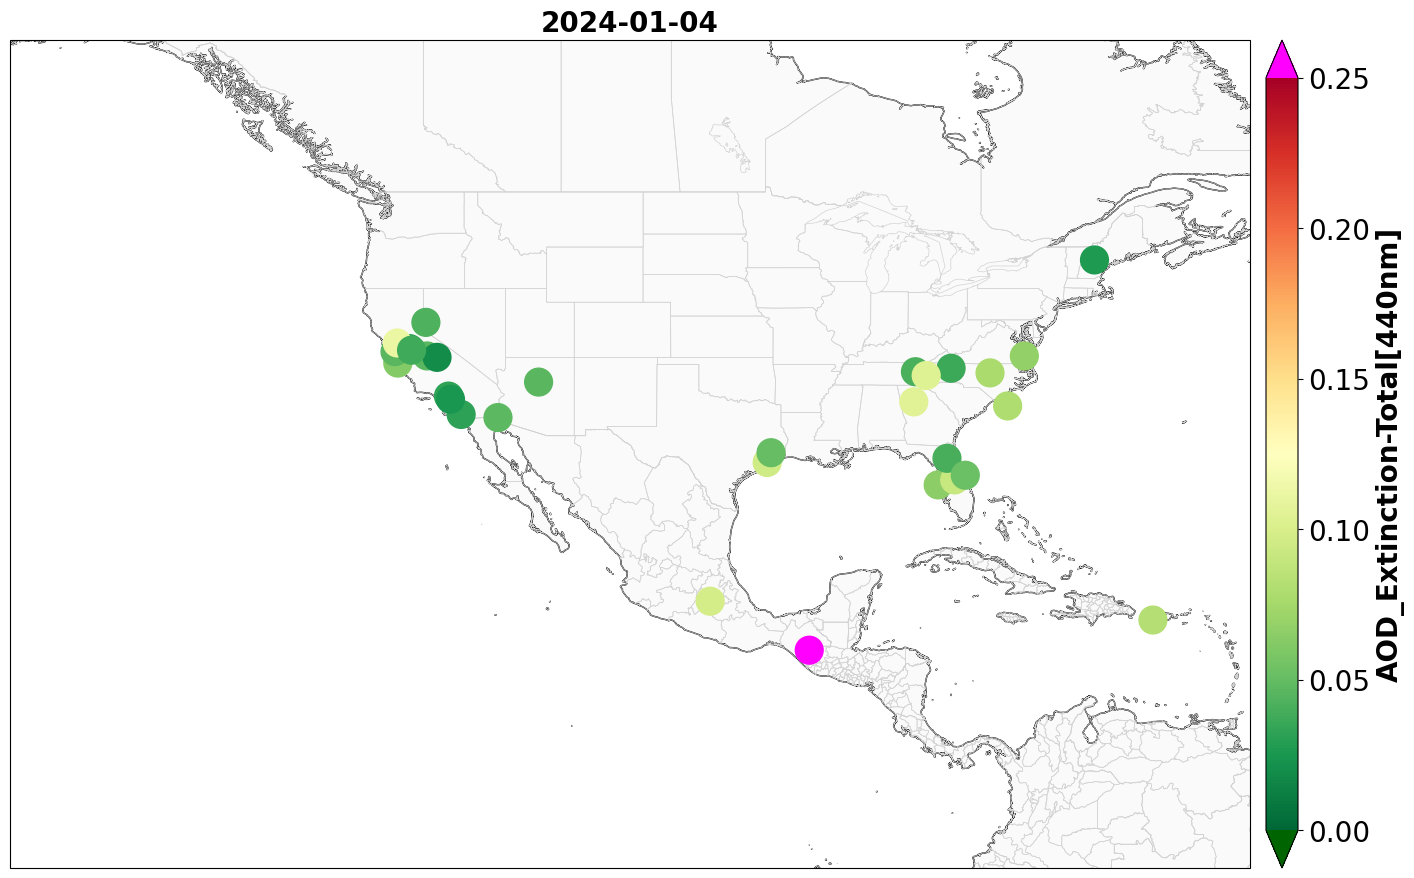

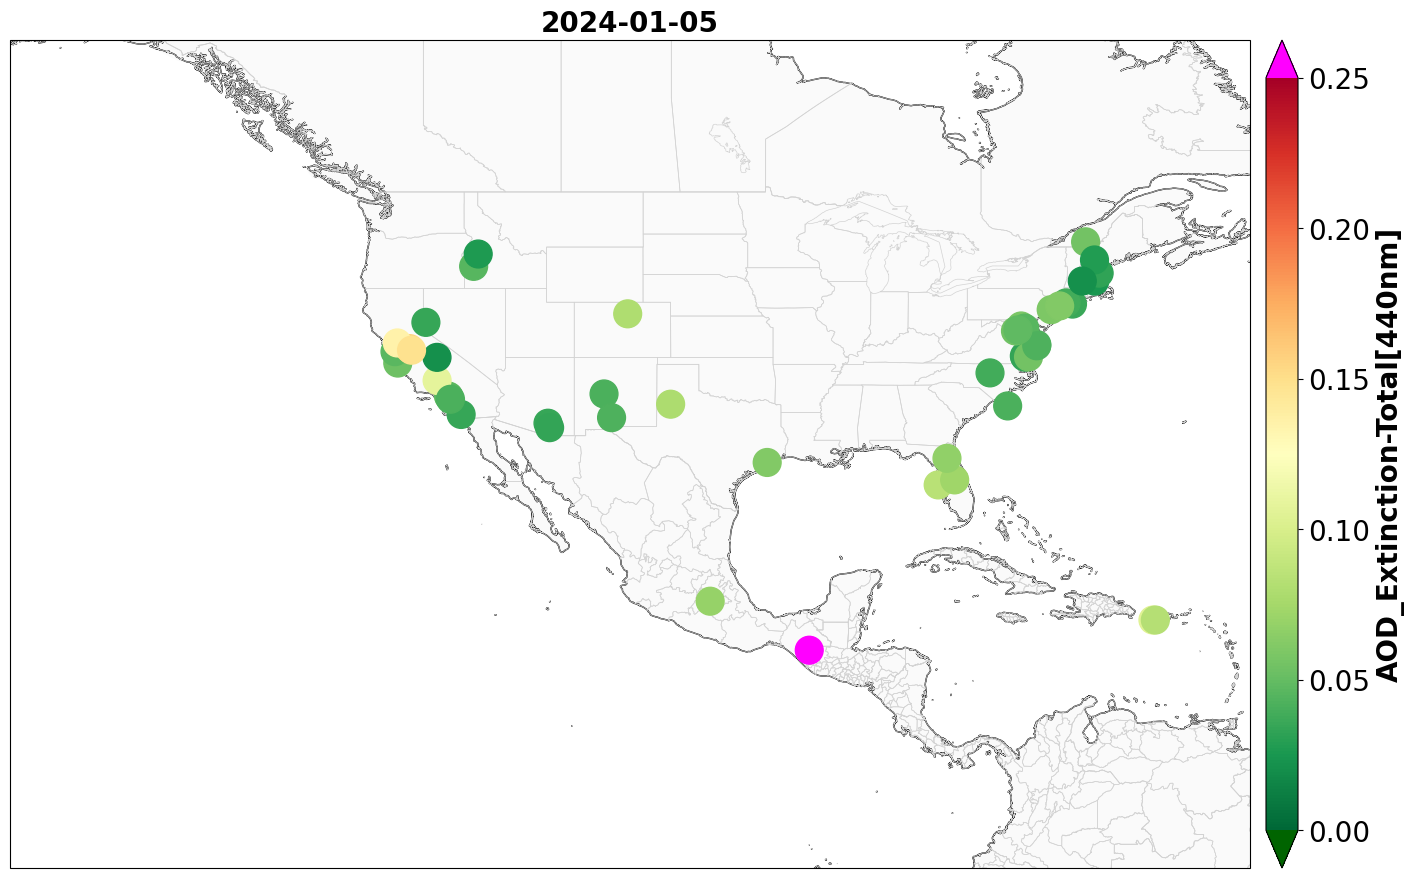

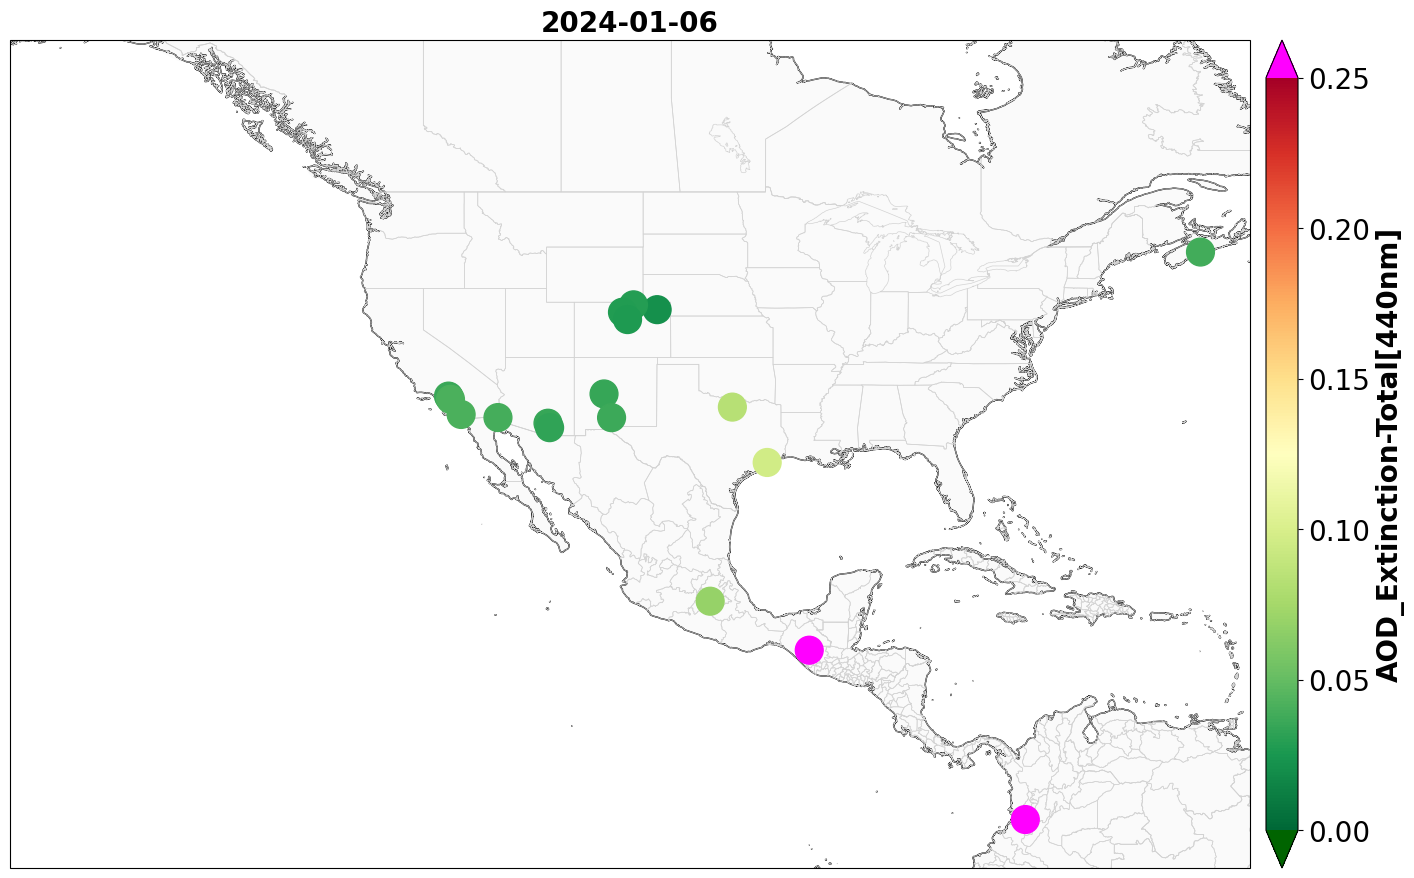

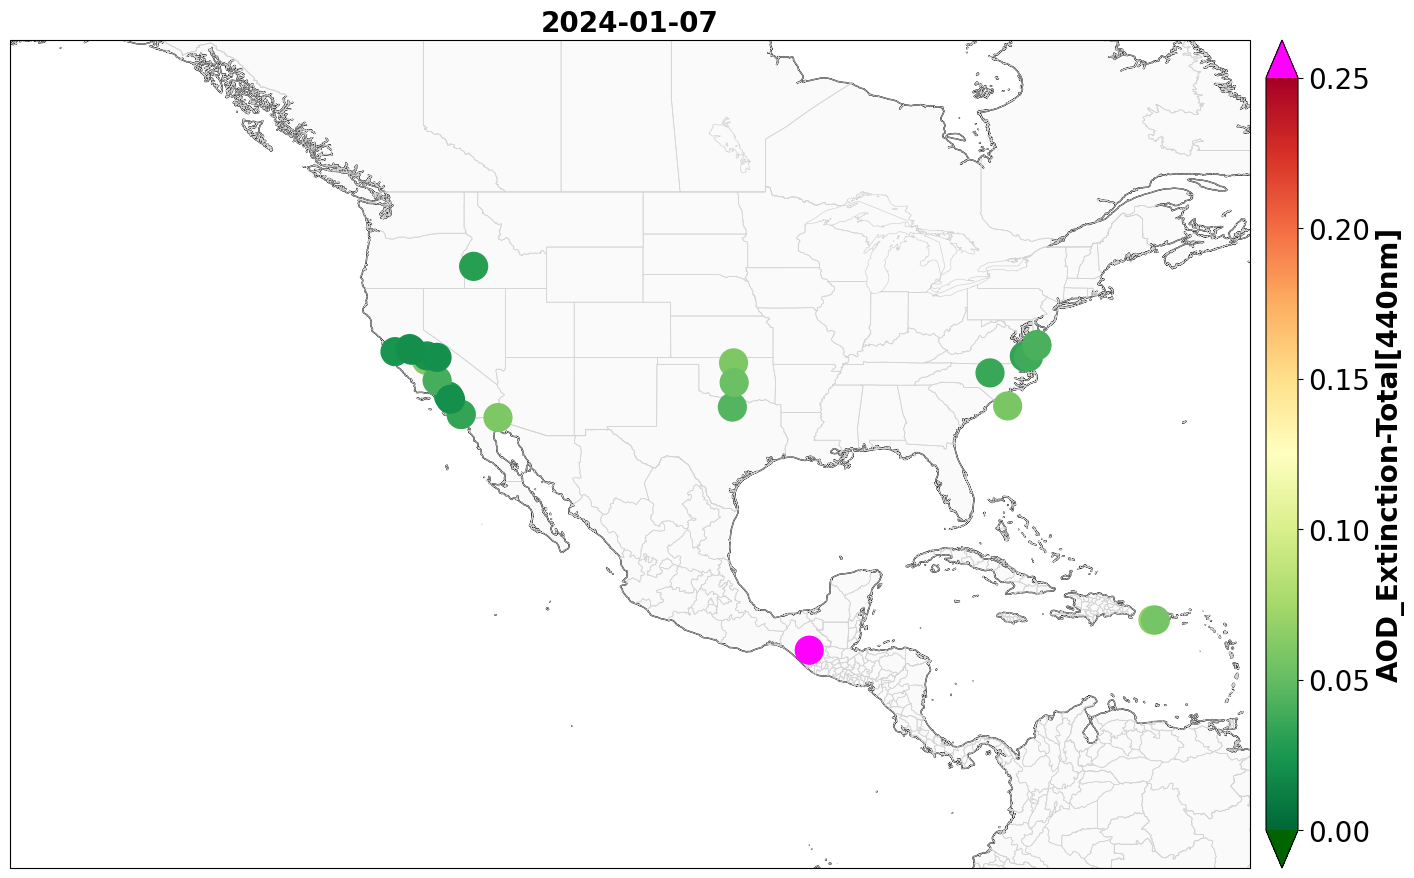

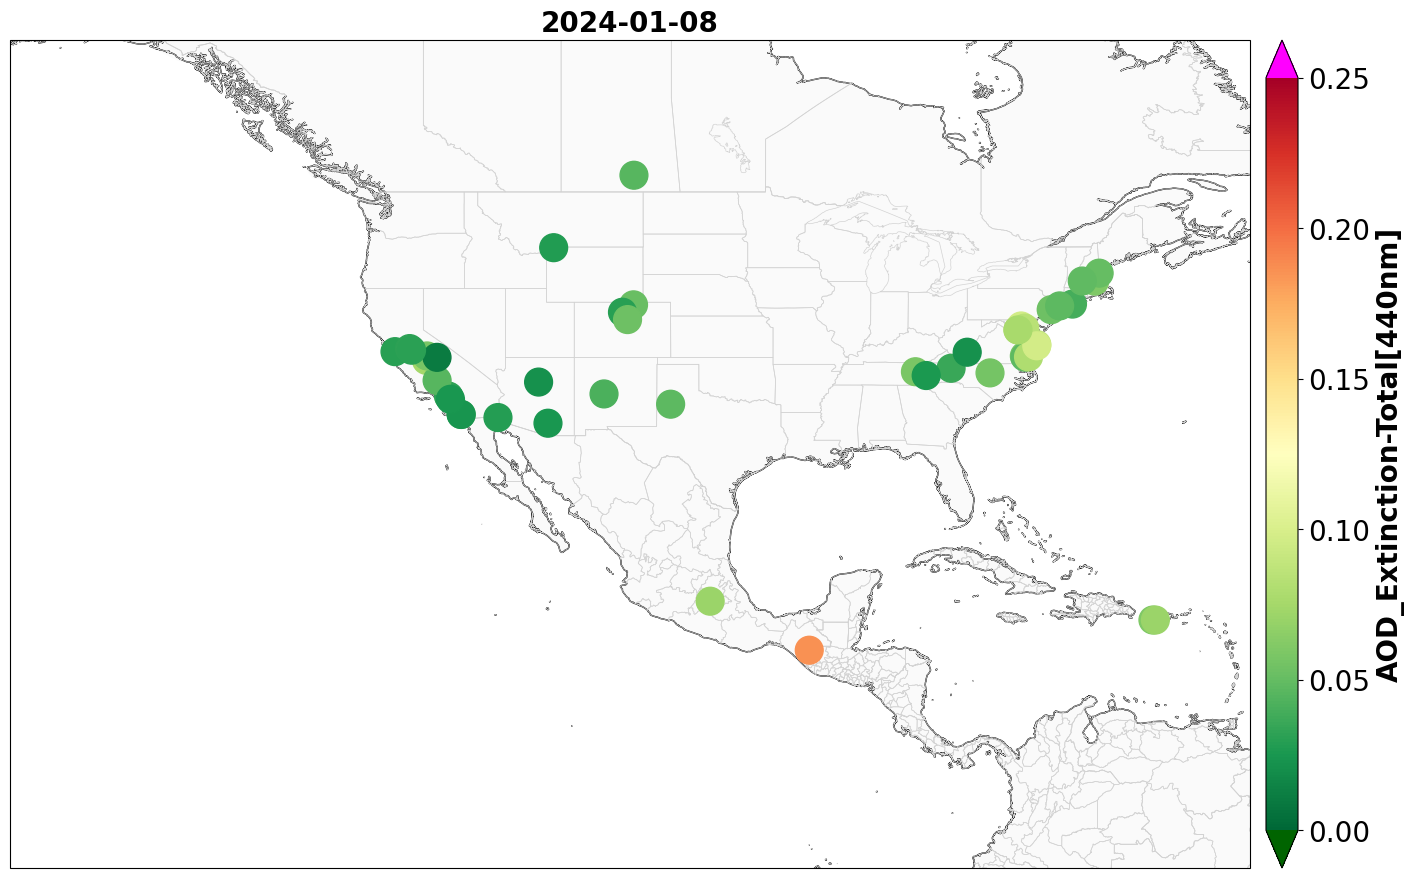

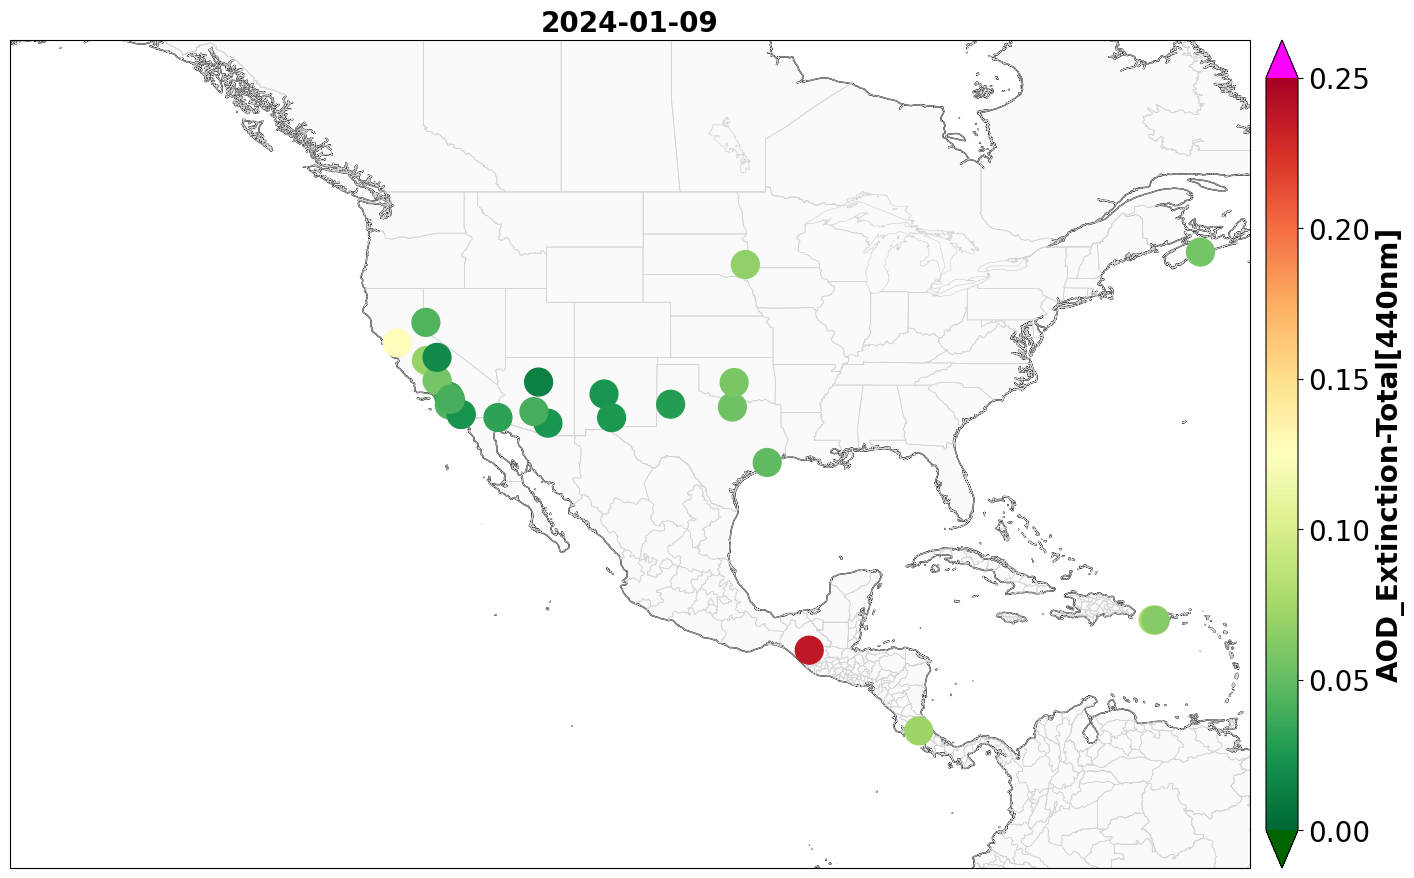

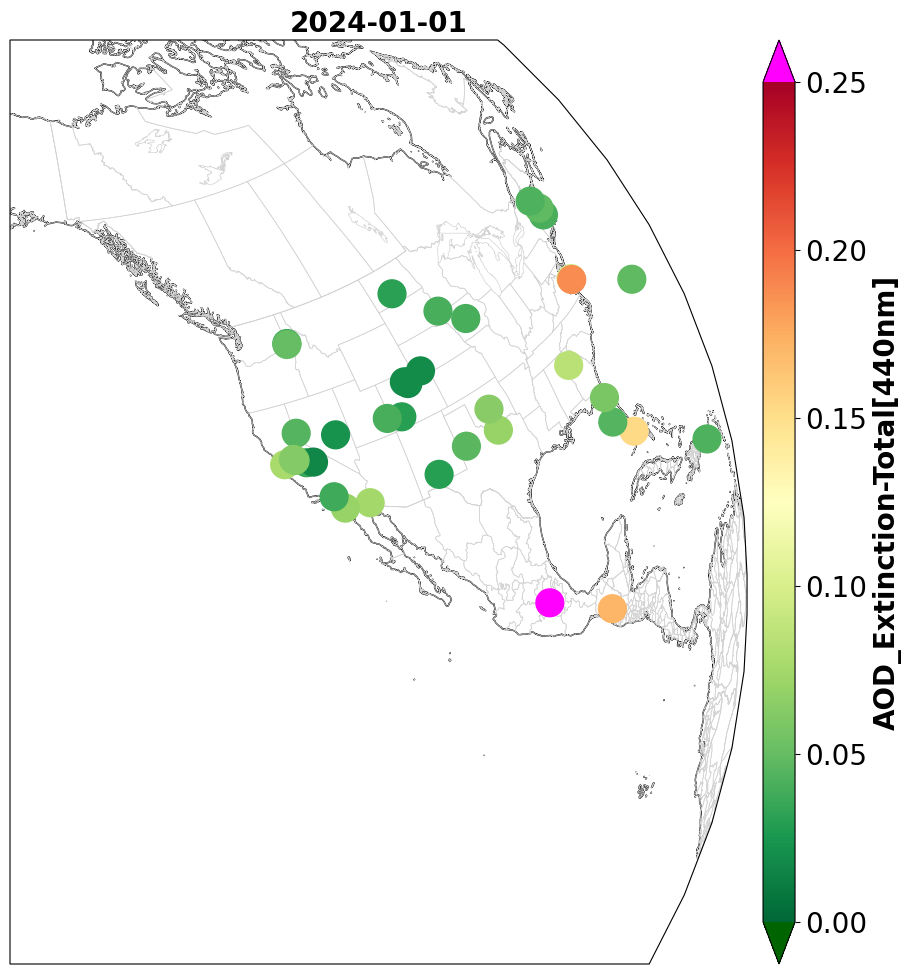

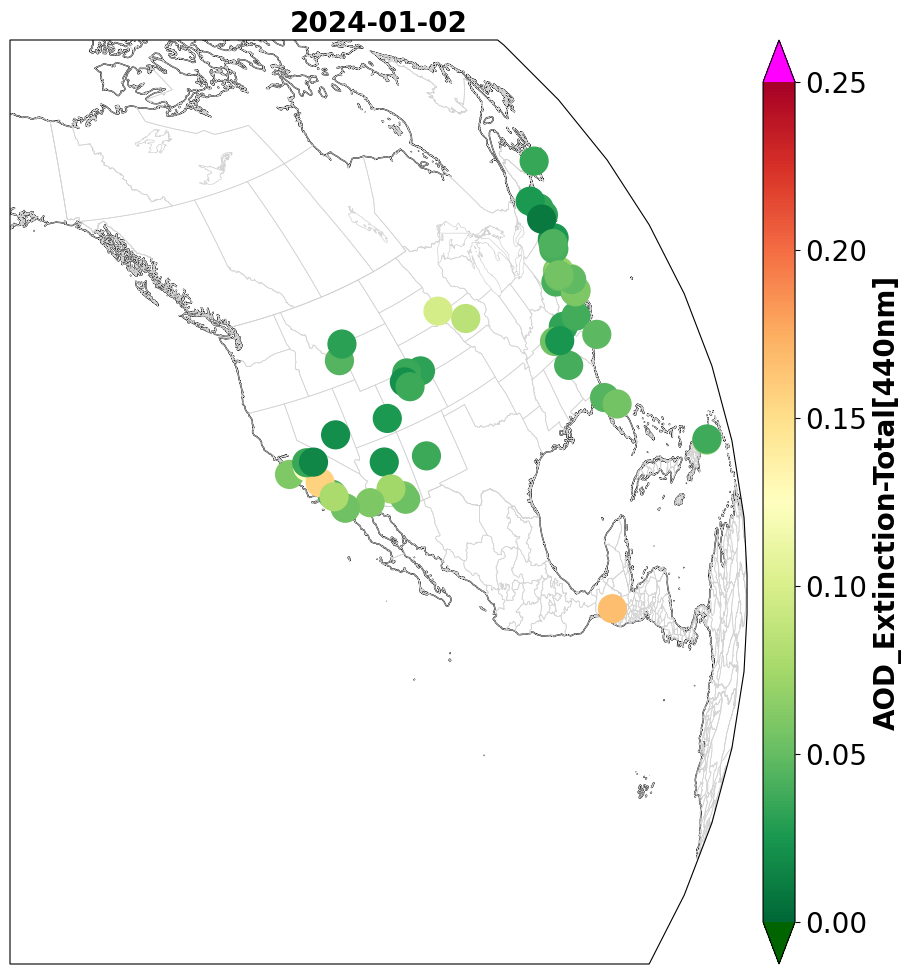

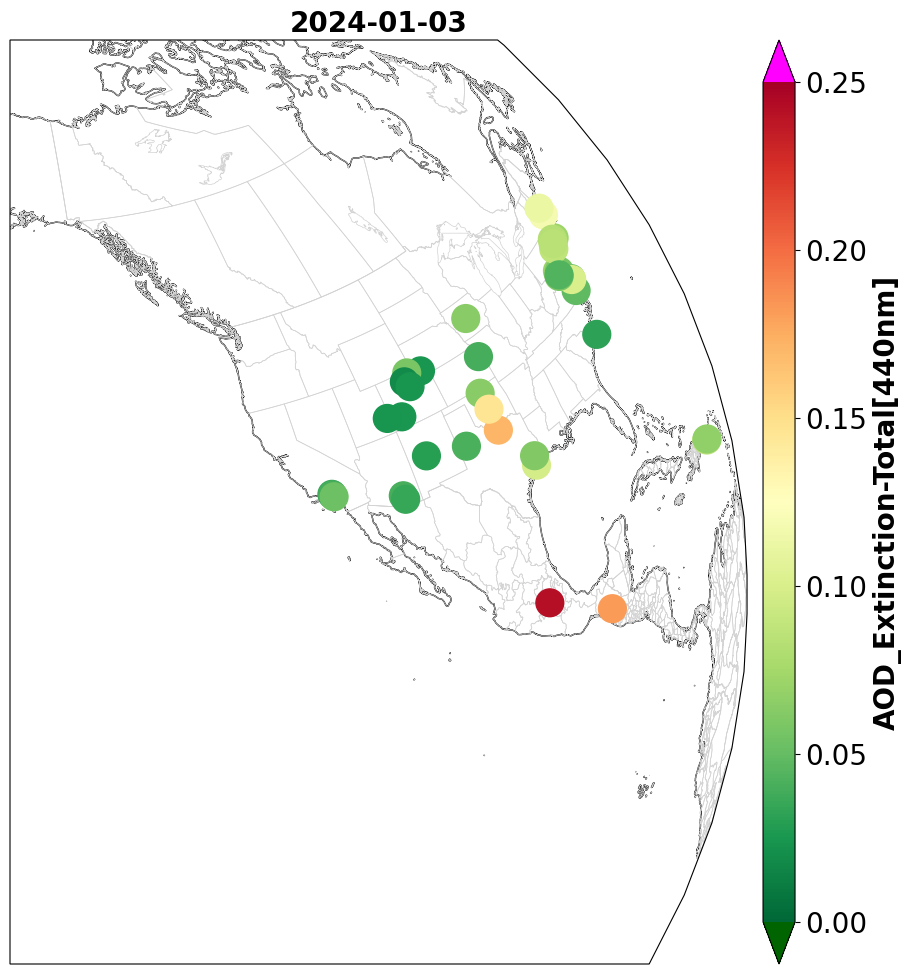

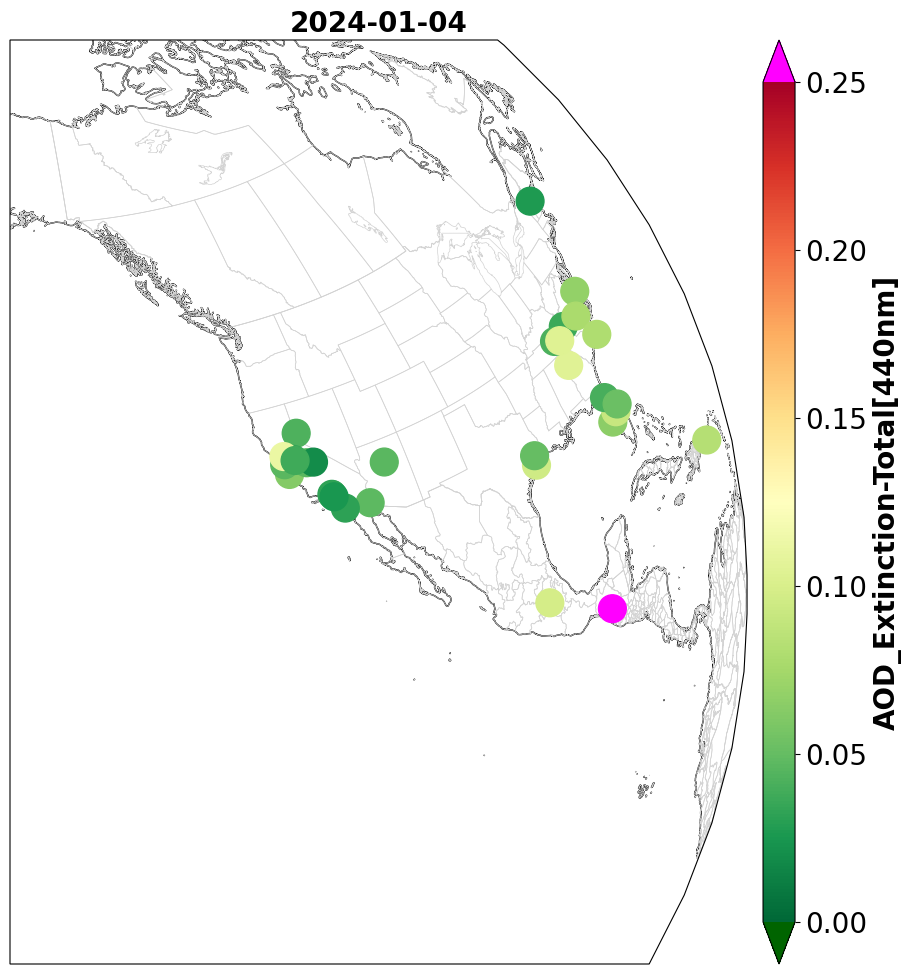

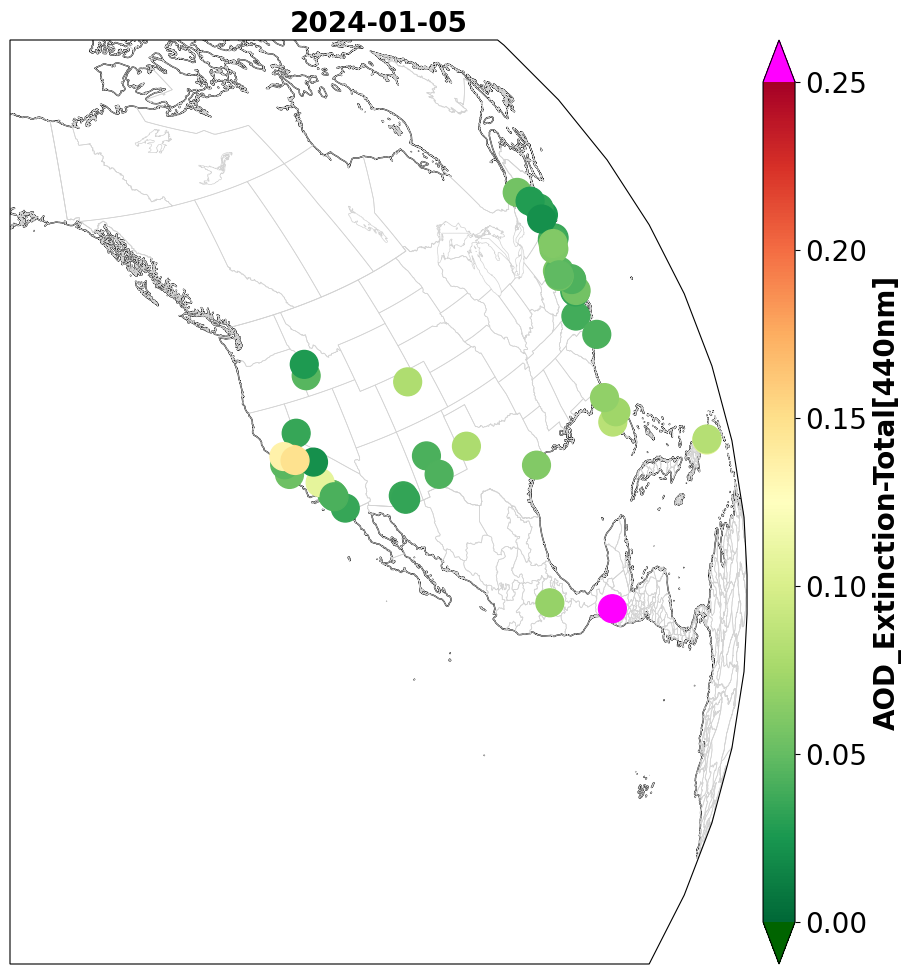

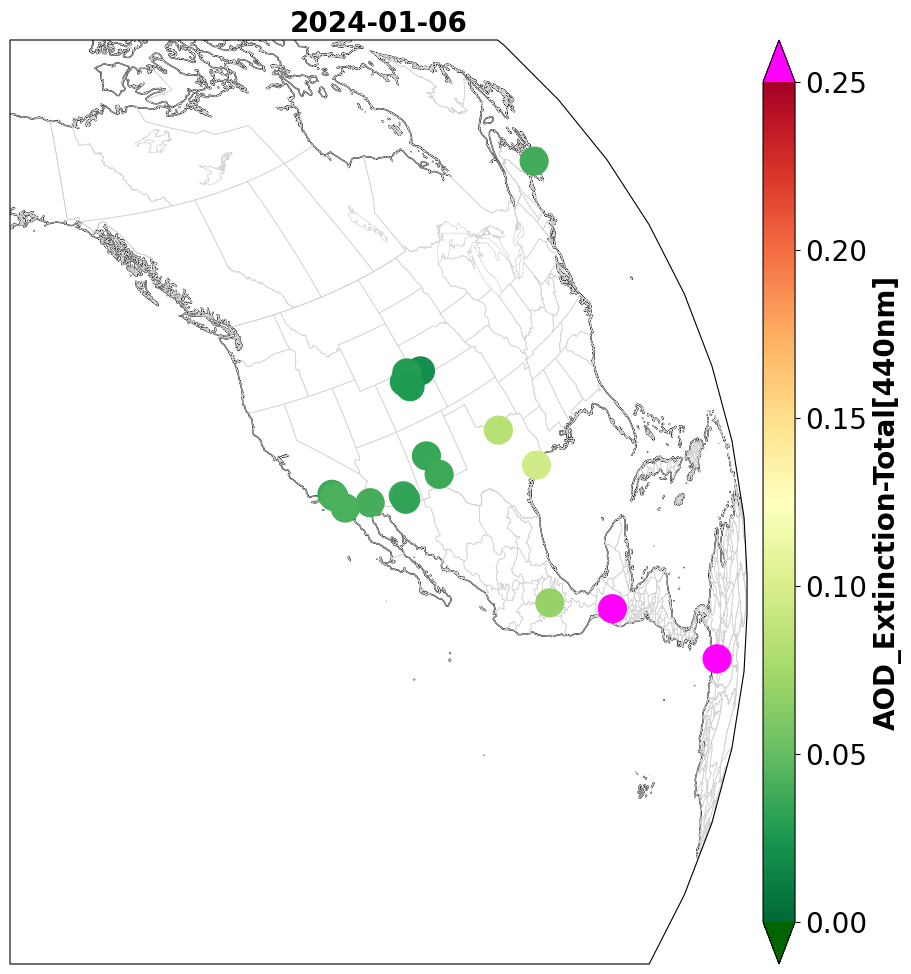

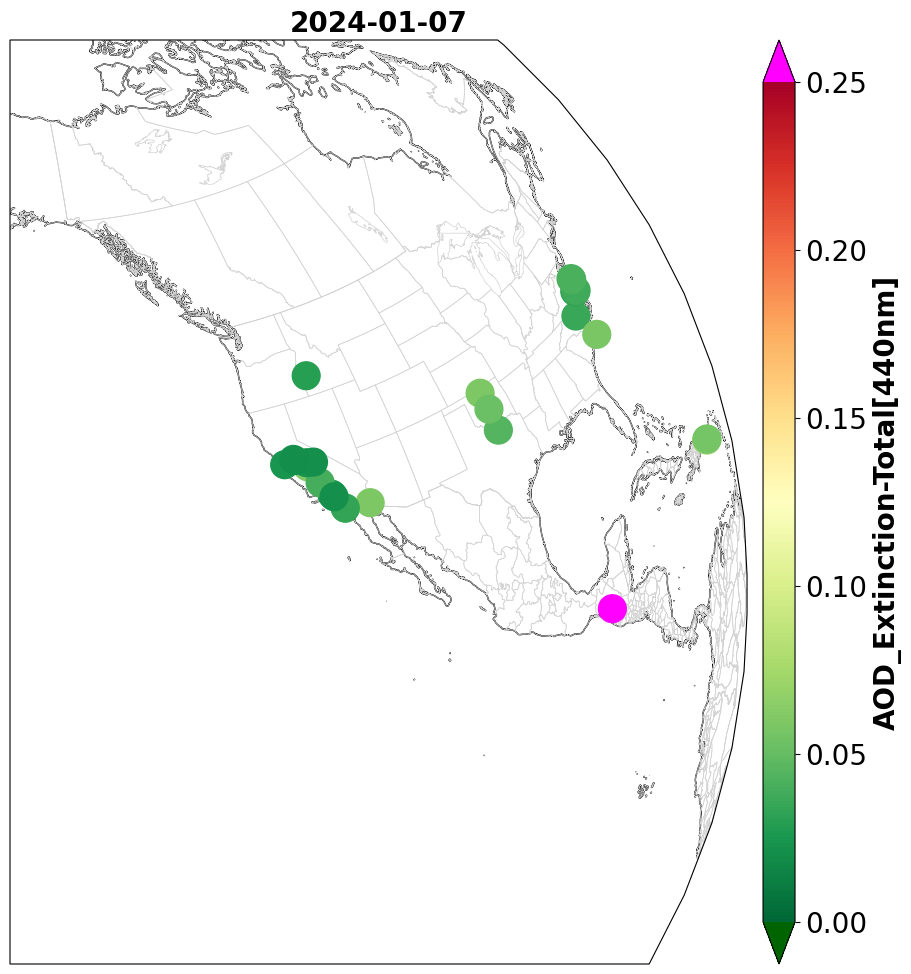

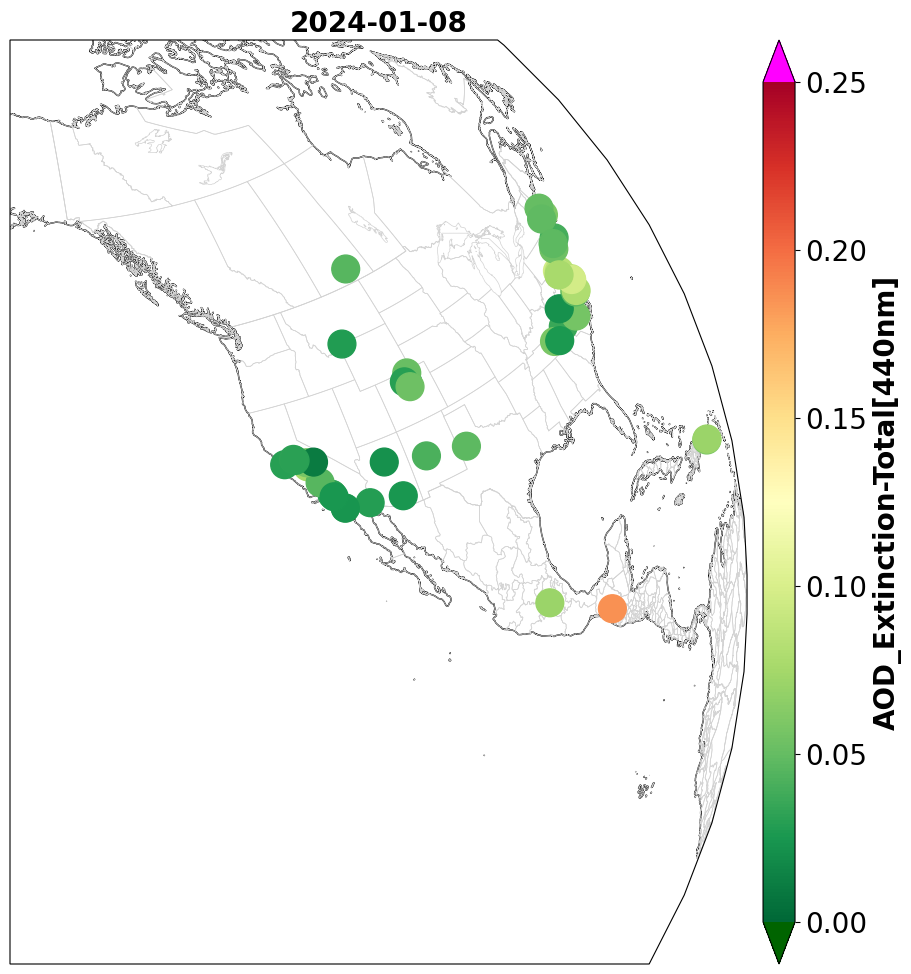

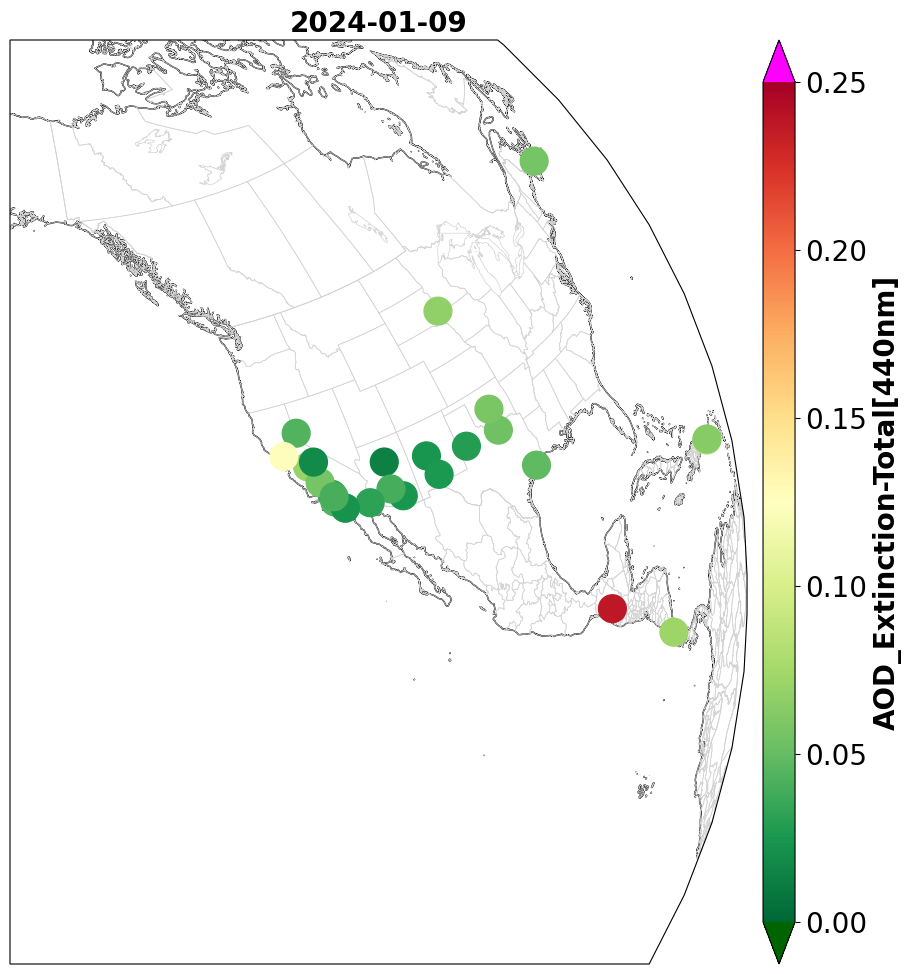

In [24]:
if len(soup.find_all('br')) > 0:

    indir = r'/content/sample_data/soup.txt'
    with open(indir ,"w") as oFile:          #writes the data scraped from "beautiful soup" to a text file on your local Google drive
        oFile.write(str(soup.text))
        oFile.close()

    df = pd.read_csv(indir,skiprows = 7)     #loads the csv data into a Pandas dataframe
    os.remove(indir)
    df = df.replace(-999.0, np.nan)                                     #replaces all -999.0 vakyes with NaN; helps with accurate data aggregation
    df[['Day','Month','Year']] = df['Date(dd:mm:yyyy)'].str.split(':',expand=True)                                #splits the date column and then joins it back together using "-" instead of ":"
    df['Date'] = df[['Year','Month','Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")       #because datetime format in python does not recognize colons
    df = df.drop(columns=['Year','Month','Day','Date(dd:mm:yyyy)'])                     #drops the old date columns, only keeps the new one
    df['Date']= pd.to_datetime(df['Date'])                                              #converts the new date column to datetime format
    df_nonwave = df[['Date','Latitude(Degrees)','Longitude(Degrees)']]
    df_wave = df.filter(like=str(wave)+'nm')

    if avg == 2:
        df['Hour'] = np.nan                                                   #This code creates a blank column "Hour".
        for i in range(len(df['Time(hh:mm:ss)'])):                            #The following for-loop truncates the last 6 characters of the Time(hh:mm:ss) column and assigns them to the new "Hour" column.
            df['Hour'][i] = df['Time(hh:mm:ss)'][i][:-6]                      #That way that new column only has the hours, while minutes and seconds are truncated.
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        df = df.groupby(['AERONET_Site','Date','Hour'])[numeric_cols].mean()
        df = df.reset_index()
        df_nonwave = df[['Date','Hour','Latitude(Degrees)','Longitude(Degrees)']]
        df_wave = df.filter(like=str(wave)+'nm')
    elif avg == 3:
        df = df.drop(columns=['Day_of_Year', 'Day_of_Year(Fraction)'])       #if the site averages are selected, the day of year, date and hour are now redundant. Instead, the code
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        df = df.groupby(['AERONET_Site'])[numeric_cols].mean()                             #groups dataset by the Aeronet site location, and takes the total time average for each location
        df = df.reset_index()
        df_nonwave = df[['Latitude(Degrees)','Longitude(Degrees)']]
        df_wave = df.filter(like=str(wave)+'nm')

    if not df_wave.empty:
        df = pd.concat([df_nonwave, df.filter(like=str(wave)+'nm')], axis=1)

        geo_df = dc(df)
        projection=ccrs.PlateCarree()
        os.makedirs('Output/PlateCarree', exist_ok=True)
        outdir_Plate='/content/Output/PlateCarree/'

        colbar='RdYlGn_r' #https://matplotlib.org/stable/tutorials/colors/colormaps.html

        if avg == 2:
            geo_df = dc(df)
            geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
            geo_df['Hour'] = geo_df['Hour'].dt.time
            geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
            geo_df = geo_df.drop(columns=['Date', 'Hour'])

            date_list = geo_df[['Date_Time']].astype(str)
            date_list = date_list.to_numpy()
            date_list = np.unique(date_list)

            for i in range(len(date_list)):
                geo_df = dc(df)
                geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
                geo_df['Hour'] = geo_df['Hour'].dt.time
                geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
                geo_df = geo_df.drop(columns=['Date', 'Hour'])

                fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
                plt.xlim([lon1,lon2])
                plt.ylim([lat1,lat2])

                # Comment next 2 lines if you don't want grey color map
                countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
                countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

                geo_df = geo_df.loc[geo_df[geo_df.columns[-1]] == date_list[i]].reset_index(drop=True)
                colbar = plt.cm.get_cmap('RdYlGn_r')
                colbar.set_extremes(under='darkgreen',over='magenta')
                cm = ax.scatter(x=geo_df[geo_df.columns[1]], y=geo_df[geo_df.columns[0]],
                                c=geo_df[geo_df.columns[2]],
                            cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1)

                ax.set_title(date_list[i]+str(' GMT'),size=20, weight='bold')

                # Add coastlines
                ax.coastlines(resolution='10m',zorder=0)

                # Add state and country boundaries
                ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
                ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

                #Add colorbar
                cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

                cbar=plt.colorbar(cm, cax=cax, extend = 'both')
                cax.set_ylabel(geo_df.columns[2],size=20, weight='bold')
                cbar.ax.tick_params(labelsize=20)

                fig.savefig(outdir_Plate+str(date_list[i][:-6])+'_level'+str(level)+'_'+str(feature_choice)+'_'+geo_df.columns[2]+'_'+str(inv_type)+'_'+str(lon1)+'_'+str(lon2)+'_'+str(lat1)+'_'+str(lat2)+'_PlateCarree.png', bbox_inches='tight',dpi=400)

        elif avg == 3:
            geo_df = dc(df)
            fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)

            # Comment next 2 lines if you don't want grey color map
            countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
            countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

            # Add coastlines
            ax.coastlines(resolution='10m',zorder=1)

            # Add state and country boundaries
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)

            plt.xlim([lon1,lon2])
            plt.ylim([lat1,lat2])
            colbar = plt.cm.get_cmap('RdYlGn_r')
            colbar.set_extremes(under='darkgreen',over='magenta')
            cm = ax.scatter(x=geo_df[geo_df.columns[1]], y=geo_df[geo_df.columns[0]],
                              c=geo_df[geo_df.columns[2]],
                          cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=2)
            ax.set_title("Site Average",size=20, weight='bold')

            #Add colorbar
            cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
            cbar=plt.colorbar(cm, cax=cax, extend = 'both')
            cax.set_ylabel(geo_df.columns[2],size=20, weight='bold')
            cbar.ax.tick_params(labelsize=20)

            fig.savefig(outdir_Plate+'SiteAverage_level'+str(level)+'_'+str(feature_choice)+'_'+geo_df.columns[2]+'_'+str(inv_type)+'_'+str(lon1)+'_'+str(lon2)+'_'+str(lat1)+'_'+str(lat2)+'_PlateCarree.png',bbox_inches='tight',dpi=400)

        else:
            #for daily averages
            date_list = geo_df[['Date']].astype(str)
            date_list = date_list.to_numpy()
            date_list = np.unique(date_list)

            for i in range(len(date_list)):
                geo_df = dc(df)

                fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
                plt.xlim([lon1,lon2])
                plt.ylim([lat1,lat2])

                # Comment next 2 lines if you don't want grey color map
                countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
                countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

                geo_df = geo_df.loc[geo_df['Date'] == date_list[i]].reset_index(drop=True)
                colbar = plt.cm.get_cmap('RdYlGn_r')
                colbar.set_extremes(under='darkgreen',over='magenta')
                cm = ax.scatter(x=geo_df[geo_df.columns[2]], y=geo_df[geo_df.columns[1]],
                            c=geo_df[geo_df.columns[3]],
                            cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1)
                ax.set_title(date_list[i],size=20, weight='bold')

                # Add coastlines
                ax.coastlines(resolution='10m',zorder=0)

                # Add state and country boundaries
                ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
                ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

                #Add colorbar
                cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
                cbar=plt.colorbar(cm, cax=cax, extend = 'both')
                cax.set_ylabel(geo_df.columns[3],size=20, weight='bold')
                cbar.ax.tick_params(labelsize=20)

                fig.savefig(outdir_Plate+str(date_list[i])+'_level'+str(level)+'_'+str(feature_choice)+'_'+geo_df.columns[3]+'_'+str(inv_type)+'_'+str(lon1)+'_'+str(lon2)+'_'+str(lat1)+'_'+str(lat2)+'.png',bbox_inches='tight',dpi=400)

        ## Define central location for Orthogrphic projection
        central_longitude = lon1 + abs(lon2 - lon2)//2
        central_latitude  = lat1 + abs(lat1 - lat2)//2

        ### ORTHO PROJECTION CELL
        projection=ccrs.Orthographic(central_longitude=central_longitude, central_latitude=central_latitude)
        geo = ccrs.Geodetic()

        os.makedirs('Output/Orthographic', exist_ok=True)
        outdir_Ortho ='/content/Output/Orthographic/'

        colbar='RdYlGn_r' #https://matplotlib.org/stable/tutorials/colors/colormaps.html

        if avg == 2:
            geo_df = dc(df)
            geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
            geo_df['Hour'] = geo_df['Hour'].dt.time
            geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
            geo_df = geo_df.drop(columns=['Date', 'Hour'])

            date_list = geo_df[['Date_Time']].astype(str)
            date_list = date_list.to_numpy()
            date_list = np.unique(date_list)

            for i in range(len(date_list)):
                geo_df = dc(df)
                geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
                geo_df['Hour'] = geo_df['Hour'].dt.time
                geo_df['Date_Time'] = geo_df.apply(lambda x : pd.datetime.combine(x['Date'],x['Hour']),1)
                geo_df = geo_df.drop(columns=['Date', 'Hour'])

                fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
                ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())

                # Comment next 2 lines if you don't want grey color map
                countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
                countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1,transform=ccrs.PlateCarree())

                geo_df = geo_df.loc[geo_df[geo_df.columns[-1]] == date_list[i]].reset_index(drop=True)
                colbar = plt.cm.get_cmap('RdYlGn_r')
                colbar.set_extremes(under='darkgreen',over='magenta')
                cm = ax.scatter(x=geo_df[geo_df.columns[1]], y=geo_df[geo_df.columns[0]],
                                c=geo_df[geo_df.columns[2]],
                            cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400, zorder=1, transform=ccrs.PlateCarree())
                ax.set_title(date_list[i]+str(' GMT'),size=20, weight='bold')

                # Add coastlines
                ax.coastlines(resolution='10m',zorder=0)

                # Add state and country boundaries
                ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
                ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

                #Add colorbar
                cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
                cbar=plt.colorbar(cm, cax=cax, extend='both')
                cax.set_ylabel(geo_df.columns[2],size=20, weight='bold')
                cbar.ax.tick_params(labelsize=20)

                fig.savefig(outdir_Ortho+str(date_list[i][:-6])+'_level'+str(level)+'_'+str(feature_choice)+'_'+geo_df.columns[2]+'_'+str(inv_type)+'_'+str(lon1)+'_'+str(lon2)+'_'+str(lat1)+'_'+str(lat2)+'.png')

        elif avg == 3:
            geo_df = dc(df)
            fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
            ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())

            # Comment next 2 lines if you don't want grey color map
            countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
            countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

            # Add coastlines
            ax.coastlines(resolution='10m',zorder=1)

            # Add state and country boundaries
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)
            ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)

            colbar = plt.cm.get_cmap('RdYlGn_r')
            colbar.set_extremes(under='darkgreen',over='magenta')
            cm = ax.scatter(x=geo_df[geo_df.columns[1]], y=geo_df[geo_df.columns[0]],
                              c=geo_df[geo_df.columns[2]],
                          cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=2,transform=ccrs.PlateCarree())

            ax.set_title("Site Averages",size=20, weight='bold')

            #Add colorbar
            cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
            plt.colorbar(cm, cax=cax, extend='both')
            cax.set_ylabel(geo_df.columns[2],size=20, weight='bold')

            fig.savefig(outdir_Ortho+'SiteAverage_level'+str(level)+'_'+str(feature_choice)+'_'+geo_df.columns[2]+'_'+str(inv_type)+'_'+str(lon1)+'_'+str(lon2)+'_'+str(lat1)+'_'+str(lat2)+'.png')

        else:
            #for daily averages
            geo_df = dc(df)
            date_list = geo_df[['Date']].astype(str)
            date_list = date_list.to_numpy()
            date_list = np.unique(date_list)

            for i in range(len(date_list)):
                geo_df = dc(df)

                fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
                ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())

                # Comment next 2 lines if you don't want grey color map
                countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
                countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

                geo_df = geo_df.loc[geo_df['Date'] == date_list[i]].reset_index(drop=True)
                colbar = plt.cm.get_cmap('RdYlGn_r')
                colbar.set_extremes(under='darkgreen',over='magenta')
                cm = ax.scatter(x=geo_df[geo_df.columns[2]], y=geo_df[geo_df.columns[1]],
                            c=geo_df[geo_df.columns[3]],
                            cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1,transform=ccrs.PlateCarree())

                ax.set_title(date_list[i],size=20, weight='bold')

                # Add coastlines
                ax.coastlines(resolution='10m',zorder=0)

                # Add state and country boundaries
                ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
                ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

                #Add colorbar
                cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
                cbar=plt.colorbar(cm, cax=cax, extend='both')
                cax.set_ylabel(geo_df.columns[3],size=20, weight='bold')
                cbar.ax.tick_params(labelsize=20)

                fig.savefig(outdir_Ortho+str(date_list[i])+'_level'+str(level)+'_'+str(feature_choice)+'_'+geo_df.columns[3]+'_'+str(inv_type)+'_'+str(lon1)+'_'+str(lon2)+'_'+str(lat1)+'_'+str(lat2)+'.png')

    else:
        print("\nWavelength not found. Please try again.")

else:
    print("\nNo data to read. Please try again.")

**Zip file download**

In [ ]:
while True:
  zip_download = str(input("Would you like to download your output in a zipped folder (y or n)?: "))
  if zip_download == 'y' or zip_download == 'Y' or zip_download == 'Yes' or zip_download == 'yes':
    shutil.make_archive('Output', 'zip', '/content/Output')  #zips all output files
    files.download('Output.zip')  #Note: Must use Chrome browser for download to work
    break
  elif zip_download == 'n' or zip_download == 'N' or zip_download == 'No' or zip_download == 'no':
    print("\nThanks! I hope you enjoyed the program.")
    break
  else:
    print("\nIncorrect input. Please try again!")

Would you like to download your output in a zipped folder (y or n)?: y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>